In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn as nn
from torch.optim import SGD as sgd
import pandas as pd
import torchviz

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [2]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.dataset = pd.read_csv(filepath)

        self.x = self.dataset.iloc[:, 1:].values  # all columns except the first one
        self.y = self.dataset.iloc[:, 0].values  # first column is the label

        # Reshape features into images (assuming images are 28x28 pixels)
        self.x = self.x.reshape(-1, 28, 28)

        # Convert to PyTorch tensors
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)

        # Normalize image pixels
        self.x = self.x / 255.0

        # Encoding labels into one-hot vectors
        self.y = F.one_hot(self.y, num_classes=10).to(float)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [3]:
train_ds = CTDataset("mnist_train.csv")

len(train_ds)

60000

In [4]:
test_ds = CTDataset("mnist_test.csv")
len(test_ds)

10000

In [5]:
train_dl = DataLoader(train_ds, batch_size=5)

In [6]:
test_dl = DataLoader(test_ds, batch_size=5)

In [7]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2, 100)  # bias=False
        self.Matrix2 = nn.Linear(100, 50)  # bias=False
        self.Matrix3 = nn.Linear(50, 10)  # bias=False
        self.R = nn.ReLU()

    def forward(self, x):
        # Converting images from matrices to vectors (AKA flattening)
        x = x.view(-1, 28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [8]:
f = MyNeuralNet()

In [18]:
if not f.training:
    f.train()


# Train model function
def train_model(dl, f, n_epochs=20, lr=0.01):
    # Optimization
    opt = sgd(f.parameters(), lr=lr)
    L = nn.CrossEntropyLoss()

    # Train model
    losses = []
    epochs = []

    # Loop over the dataset multiple times
    for epoch in range(n_epochs):
        print(f"Epoch {epoch}")
        N = len(dl) # 12'000 batches
        
        # Loop over all batches
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            opt.zero_grad()
            loss_value = L(f(x), y)
            loss_value.backward()
            opt.step()
            # Store training data for plotting
            epochs.append(epoch + i / N) # epochs.append(epoch + i / N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [21]:
epoch_data, loss_data = train_model(train_dl, f)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


Text(0.5, 1.0, 'Cross Entropy (per batch)')

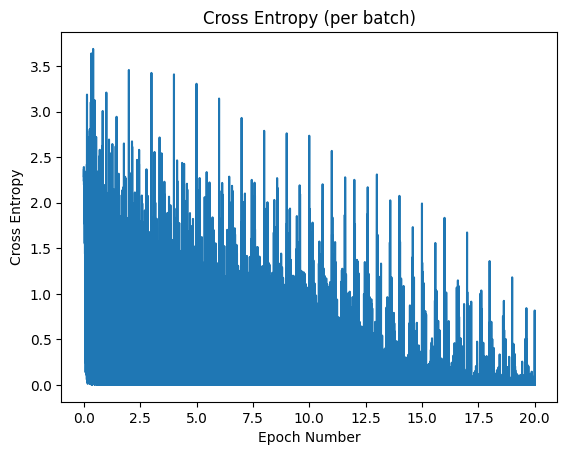

In [11]:
plt.plot(epoch_data, loss_data)
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy (per batch)")

In [12]:
epoch_data = epoch_data.reshape(20,-1).mean(axis=1)

In [13]:
loss_data = loss_data.reshape(20,-1).mean(axis=1)

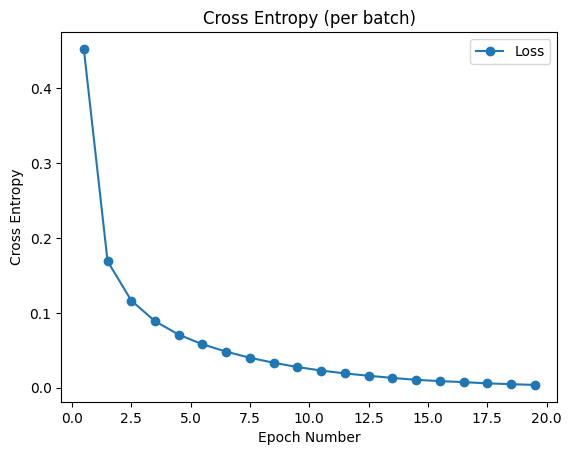

In [14]:
plt.plot(epoch_data, loss_data, marker='o', label='Loss')
plt.xlabel("Epoch Number")
plt.ylabel("Cross Entropy")
plt.title("Cross Entropy (per batch)")
plt.legend()
plt.savefig("plt.png")

In [15]:
# test_x, test_y = test_ds[:]
# yhats = f(test_x).argmax(axis=1)

In [16]:
# fig, ax = plt.subplots(10,4,figsize=(10,15))
# for i in range(40):
#     plt.subplot(10,4,i+1)
#     plt.imshow(test_x[i])
#     plt.title(f'Predicted Digit: {yhats[i]}')
# fig.tight_layout()
# plt.show()

In [22]:
# Assuming you have 'test_loader' containing test data and labels
correct_predictions = 0
total_samples = 0

# Set the model to evaluation mode
if f.training:
    f.eval()

# Iterate over the test data
with torch.no_grad():
    for x, y in test_dl:
        # Make predictions
        outputs = f(x)

        # Get predicted class labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Convert one-hot encoded labels to class indices
        y = torch.argmax(y, dim=1)
        
        # Compare predicted labels with actual labels
        correct_predictions += (predicted_labels == y).sum().item()
        total_samples += y.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_samples

print(f"Loss: {loss_data[len(loss_data)-1]:.9f}")
print(f"Total samples: {total_samples}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")

Loss: 0.000000215
Total samples: 10000
Correct predictions: 9799
Accuracy: 97.99%
